# Objective:

Comparing DNN and LEAR ensemble models as a benchmark and LSTM model using same sets of Train and Test datas. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Libraries for reading data
import epftoolbox
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler

In [3]:
# Import Libraries for Model Evaluation
from epftoolbox.evaluation import MAE 
from epftoolbox.evaluation import RMSE 
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE

# LSTM Model for EPEX-BE Market

In [4]:
# Load data into dataframe
df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date='12/27/2016', end_test_date='12/24/2018')
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


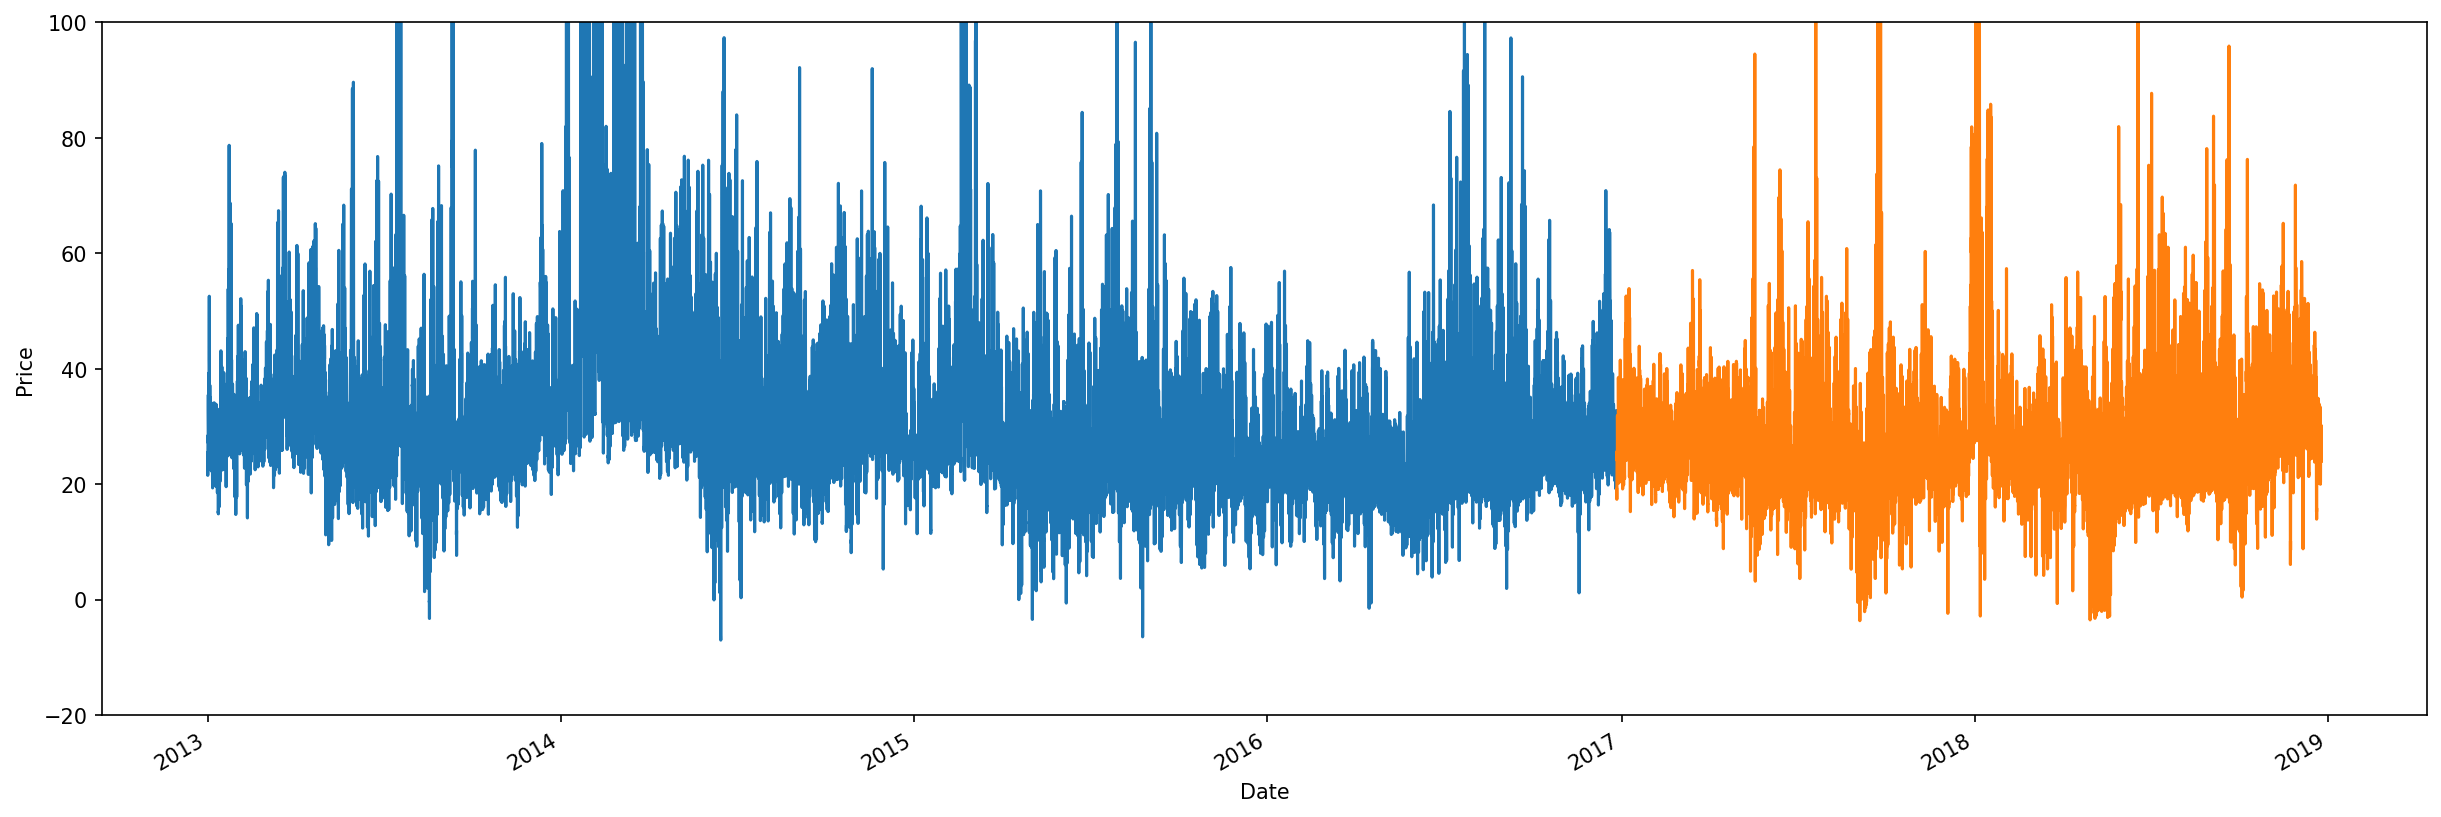

In [5]:
import matplotlib.pyplot as plt

# ploting Train (Blue) and Test (Orange) data

plt.figure(figsize=(20,6) ,dpi=150)

plt.plot(df_train.Price)
plt.plot(df_test.Price)
plt.ylim(-20, 100)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('PJM_A.png')

In [6]:
# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

In [7]:
# Function to create data for LSTM
def create_lstm_data(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [8]:
# Create LSTM model for 24 LookBack

predict = 24
look_back = 24

Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17520, 1)


In [9]:
# Create LSTM Model
#Start Time
st_24 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_24 = time.time()

Epoch 1/12
492/492 [==============================] - 37s 54ms/step - loss: 3.6319e-04 - val_loss: 5.2907e-05
Epoch 2/12
492/492 [==============================] - 24s 49ms/step - loss: 1.8565e-04 - val_loss: 3.2106e-05
Epoch 3/12
492/492 [==============================] - 24s 48ms/step - loss: 1.2148e-04 - val_loss: 4.9832e-05
Epoch 4/12
492/492 [==============================] - 24s 49ms/step - loss: 1.1812e-04 - val_loss: 2.1639e-05
Epoch 5/12
492/492 [==============================] - 24s 49ms/step - loss: 1.1217e-04 - val_loss: 1.9552e-05
Epoch 6/12
492/492 [==============================] - 25s 50ms/step - loss: 1.1263e-04 - val_loss: 4.9008e-05
Epoch 7/12
492/492 [==============================] - 25s 50ms/step - loss: 1.0891e-04 - val_loss: 2.2301e-05
Epoch 8/12
492/492 [==============================] - 23s 47ms/step - loss: 1.0973e-04 - val_loss: 2.3350e-05
Epoch 9/12
492/492 [==============================] - 23s 47ms/step - loss: 1.0742e-04 - val_loss: 2.2748e-05
Epoch 10/1

### predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_24 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_24.append(output_data)
    
#Creating List for output
Output_24 = [elem for twod in predicted_values_24 for elem in twod]
predicted_values_24 = scaler.inverse_transform(Output_24)

#Creating Data for Observed and Predicted Values 
res = pd.DataFrame(Xtest[look_back+predict:], index = Xtest.index[look_back+predict:])
res['Predicted_24'] = predicted_values_24

In [11]:
# Create LSTM model for 48 LookBack

predict = 24
look_back = 48

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]
Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17544, 1)


In [12]:
# Create LSTM Model
#Start Time
st_48 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_48 = time.time()

Epoch 1/12
491/491 [==============================] - 60s 107ms/step - loss: 3.9481e-04 - val_loss: 7.4254e-05
Epoch 2/12
491/491 [==============================] - 51s 104ms/step - loss: 1.9346e-04 - val_loss: 3.1041e-05
Epoch 3/12
491/491 [==============================] - 50s 103ms/step - loss: 1.2941e-04 - val_loss: 2.5653e-05
Epoch 4/12
491/491 [==============================] - 50s 102ms/step - loss: 1.1639e-04 - val_loss: 2.2157e-05
Epoch 5/12
491/491 [==============================] - 51s 104ms/step - loss: 1.1331e-04 - val_loss: 3.0397e-05
Epoch 6/12
491/491 [==============================] - 50s 103ms/step - loss: 1.0947e-04 - val_loss: 2.0442e-05
Epoch 7/12
491/491 [==============================] - 49s 101ms/step - loss: 1.0958e-04 - val_loss: 1.6840e-05
Epoch 8/12
491/491 [==============================] - 50s 102ms/step - loss: 1.0170e-04 - val_loss: 1.4855e-05
Epoch 9/12
491/491 [==============================] - 50s 102ms/step - loss: 1.0019e-04 - val_loss: 1.8557e-05
E

In [13]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_48 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_48.append(output_data)
    
#Creating List for output
Output_48 = [elem for twod in predicted_values_48 for elem in twod]
predicted_values_48 = scaler.inverse_transform(Output_48)

#Creating Data for Observed and Predicted Values 
res['Predicted_48'] = predicted_values_48

1/1 [==============================] - 0s 49ms/step


In [14]:
# Create LSTM model for 96 LookBack

predict = 24
look_back = 96

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]
Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17592, 1)


In [15]:
# Create LSTM Model
#Start Time
st_96 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_96 = time.time()

Epoch 1/12
491/491 [==============================] - 139s 267ms/step - loss: 4.1267e-04 - val_loss: 8.0570e-05
Epoch 2/12
491/491 [==============================] - 127s 259ms/step - loss: 2.1674e-04 - val_loss: 3.8726e-05
Epoch 3/12
491/491 [==============================] - 123s 251ms/step - loss: 1.3064e-04 - val_loss: 3.6636e-05
Epoch 4/12
491/491 [==============================] - 124s 252ms/step - loss: 1.2139e-04 - val_loss: 2.0962e-05
Epoch 5/12
491/491 [==============================] - 124s 252ms/step - loss: 1.1666e-04 - val_loss: 2.0056e-05
Epoch 6/12
491/491 [==============================] - 123s 251ms/step - loss: 1.1248e-04 - val_loss: 1.9442e-05
Epoch 7/12
491/491 [==============================] - 124s 253ms/step - loss: 1.1761e-04 - val_loss: 2.6495e-05
Epoch 8/12
491/491 [==============================] - 124s 253ms/step - loss: 1.0710e-04 - val_loss: 2.0190e-05
Epoch 9/12
491/491 [==============================] - 123s 251ms/step - loss: 1.0543e-04 - val_loss: 6.9

In [16]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_96 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_96.append(output_data)
    
#Creating List for output
Output_96 = [elem for twod in predicted_values_96 for elem in twod]
predicted_values_96 = scaler.inverse_transform(Output_96)

#Creating Data for Observed and Predicted Values 
res['Predicted_96'] = predicted_values_96

1/1 [==============================] - 0s 17ms/step


In [17]:
res.head(10)

,Price,Predicted_24,Predicted_48,Predicted_96
Date,,,,
2016-12-27 00:00:00,19.113045,19.997148,19.370081,20.286462
2016-12-27 01:00:00,18.042768,19.406155,19.069730,19.804429
2016-12-27 02:00:00,17.587395,18.867941,18.810918,19.452223
2016-12-27 03:00:00,17.399361,18.667212,18.803851,19.440202
2016-12-27 04:00:00,17.804108,18.906465,19.124368,19.831352
2016-12-27 05:00:00,19.129995,18.535261,18.719921,19.567082
2016-12-27 06:00:00,22.209875,19.303799,19.360855,20.316779
2016-12-27 07:00:00,24.167822,20.059248,19.970587,21.029701
2016-12-27 08:00:00,24.541495,22.736943,22.487134,23.589691


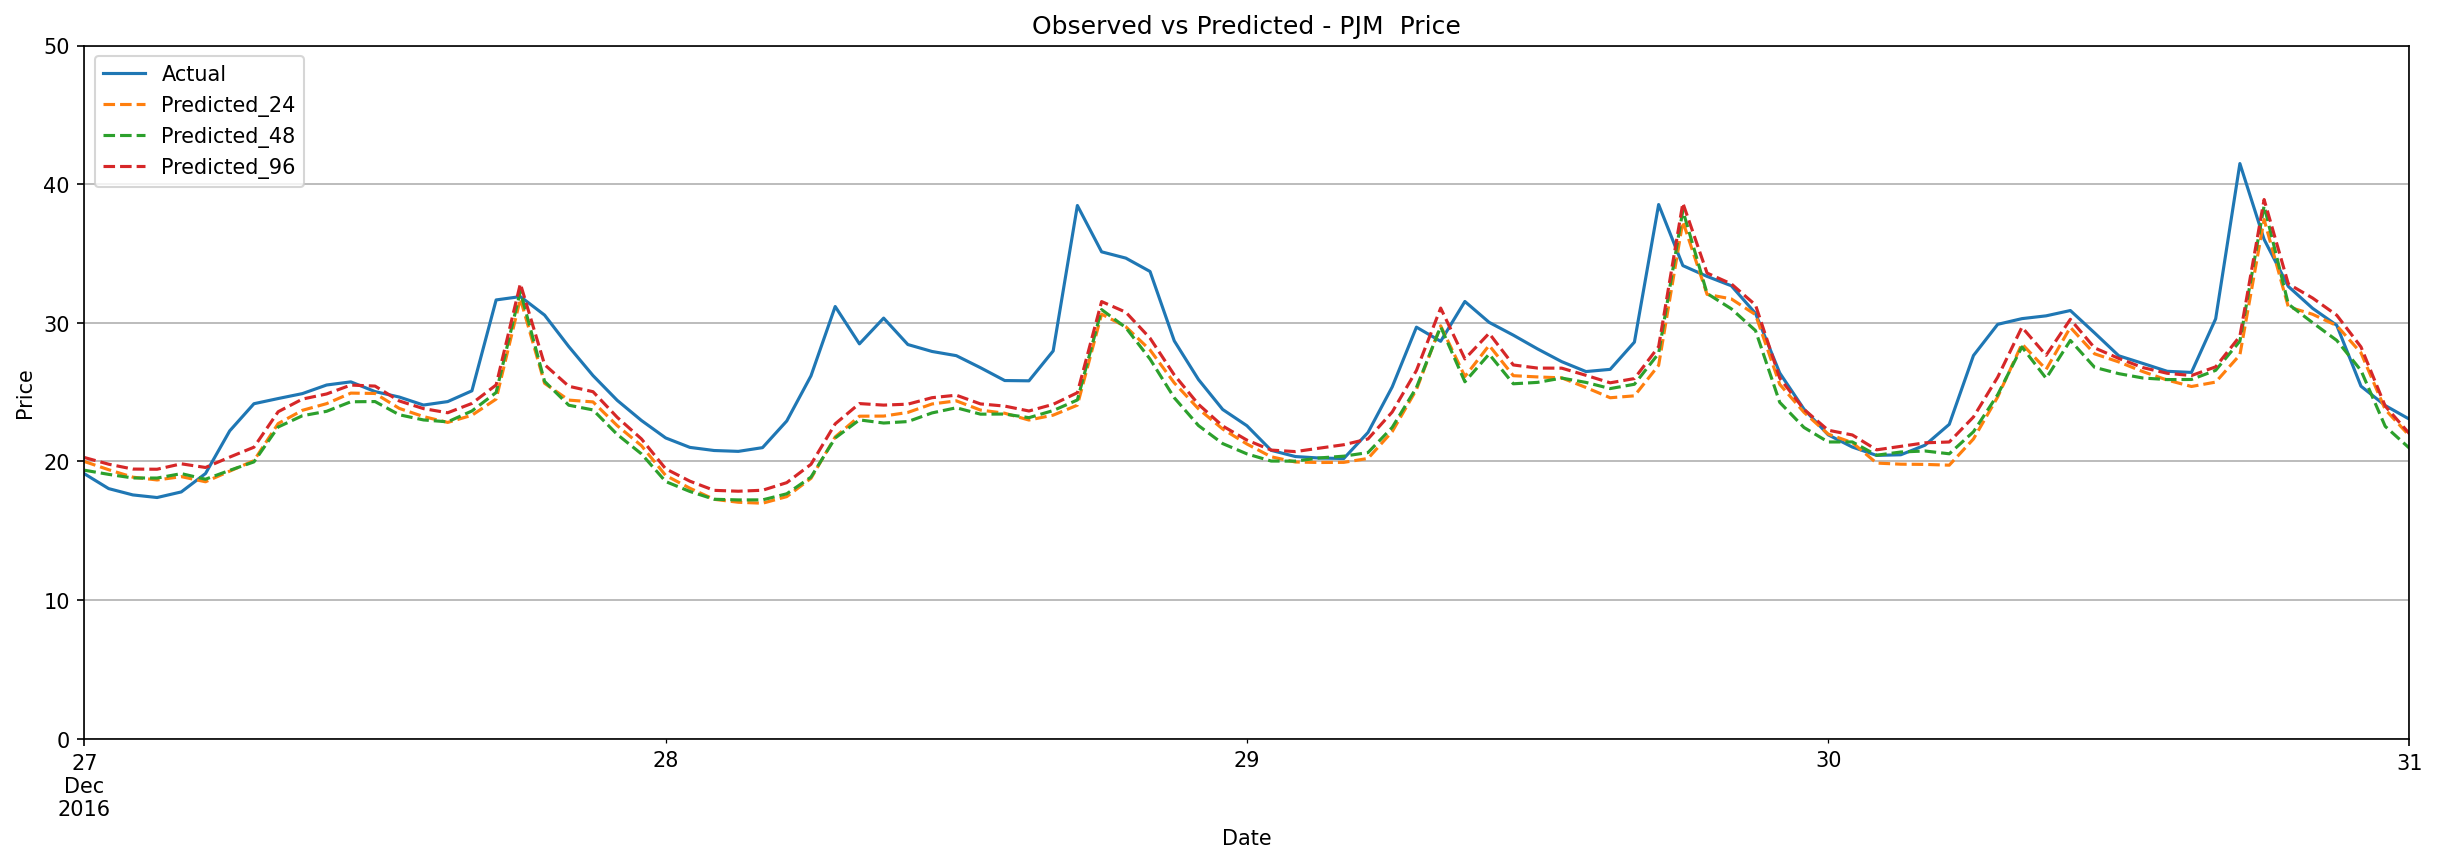

In [18]:
# ploting Observed and predicted values for 4 days 
plt.figure(figsize=(20,6) ,dpi=150)

ax1 = res.Price.plot(grid=True, label='Actual')
ax2 = res.Predicted_24.plot(grid=True, label='Predicted_24',linestyle='--')
ax3 = res.Predicted_48.plot(grid=True, label='Predicted_48',linestyle='--')
ax4 = res.Predicted_96.plot(grid=True, label='Predicted_96',linestyle='--')


ax1.set_ylim(0, 50)
ax2.set_ylim(0, 50)
ax3.set_ylim(0, 50)
ax4.set_ylim(0, 50)

plt.title('Observed vs Predicted - PJM  Price')
plt.xlim([datetime.date(2016,12,27), datetime.date(2016, 12, 31)])
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc ="best")
plt.savefig('PJM_P.png')
plt.show()

In [19]:
# Model Evaluation for LSTM for 24
MAE_l_24 = MAE(p_pred=res.Predicted_24, p_real=res.Price)
RMSE_l_24 = RMSE(p_pred=res.Predicted_24, p_real=res.Price)
MAPE_l_24 = MAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
sMAPE_l_24 = sMAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
MASE_l_24 = MASE(p_pred=res.Predicted_24, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_24 = rMAE(p_pred=res.Predicted_24, p_real=res.Price)

In [20]:
# Model Evaluation for LSTM for 48
MAE_l_48 = MAE(p_pred=res.Predicted_48, p_real=res.Price)
RMSE_l_48 = RMSE(p_pred=res.Predicted_48, p_real=res.Price)
MAPE_l_48 = MAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
sMAPE_l_48 = sMAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
MASE_l_48 = MASE(p_pred=res.Predicted_48, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_48 = rMAE(p_pred=res.Predicted_48, p_real=res.Price)

In [21]:
# Model Evaluation for LSTM for 96
MAE_l_96 = MAE(p_pred=res.Predicted_96, p_real=res.Price)
RMSE_l_96 = RMSE(p_pred=res.Predicted_96, p_real=res.Price)
MAPE_l_96 = MAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
sMAPE_l_96 = sMAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
MASE_l_96 = MASE(p_pred=res.Predicted_96, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_96 = rMAE(p_pred=res.Predicted_96, p_real=res.Price)

# DNN ensemble Model for PJM Market

In [22]:
# Read the predicted datas using benchmark models in the paper 
forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' +
                     'forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv', index_col=0)
# Transforming indices to datetime format
forecast.index = pd.to_datetime(forecast.index)
# Reading data from the NP market
df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date=forecast.index[0],
                        end_test_date=forecast.index[-1])
#predicted price
fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
fc_LEAR_ensemble = forecast.loc[:, ['LEAR Ensemble']]
#Real price
real_price = df_test.loc[:, ['Price']]

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


In [23]:
#Model Evaluation for DNN in Paper
MAE_p = MAE(p_pred=fc_DNN_ensemble, p_real=real_price)
RMSE_p = RMSE(p_pred=fc_DNN_ensemble, p_real=real_price)
MAPE_p = MAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
sMAPE_p = sMAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
MASE_p = MASE(p_pred=fc_DNN_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_p = rMAE(p_pred=fc_DNN_ensemble, p_real=real_price)

In [24]:
#Model Evaluation for LEAR in Paper
MAE_le = MAE(p_pred=fc_LEAR_ensemble, p_real=real_price)
RMSE_le = RMSE(p_pred=fc_LEAR_ensemble, p_real=real_price)
MAPE_le = MAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
sMAPE_le = sMAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
MASE_le = MASE(p_pred=fc_LEAR_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_le = rMAE(p_pred=fc_LEAR_ensemble, p_real=real_price)

## Summary table for Model evaluation

In [25]:
#Summary table for Model evaluation
from tabulate import tabulate
print(tabulate([['Mean Absolute Error (MAE):', MAE_p ,MAE_le,MAE_l_24,MAE_l_48,MAE_l_96], 
                ['Root Mean Square Error (RMSE):',RMSE_p,RMSE_le,RMSE_l_24,RMSE_l_48,RMSE_l_96],
                ['Mean Absolute Percentage Error (MAPE):',MAPE_p,MAPE_le,MAPE_l_24,MAPE_l_48,MAPE_l_96],
               ['symmetric Mean Absolute Percentage Error (sMAPE):',sMAPE_p,sMAPE_le,sMAPE_l_24,sMAPE_l_48,sMAPE_l_96],
                ['Mean Absolute Scaled Error (MASE):',MASE_p,MASE_le,MASE_l_24,MASE_l_48,MASE_l_96],
                ['relative Mean Absolute Error(rMAE):',rMAE_p,rMAE_le,rMAE_l_24,rMAE_l_48,rMAE_l_96]],headers=['Evaluation for PJM Market','DNN_ensem','LEAR_ensem','LSTM-24','LSTM-48','LSTM-96']))

Evaluation for PJM Market                            DNN_ensem    LEAR_ensem    LSTM-24    LSTM-48    LSTM-96
-------------------------------------------------  -----------  ------------  ---------  ---------  ---------
Mean Absolute Error (MAE):                            2.86217       3.01302    4.8409     4.89098    4.76671
Root Mean Square Error (RMSE):                        5.04049       5.12747    7.64908    7.68574    7.57592
Mean Absolute Percentage Error (MAPE):               27.4775       30.134     34.1687    34.271     34.4963
symmetric Mean Absolute Percentage Error (sMAPE):    11.3308       11.9798    18.8925    19.1729    18.3251
Mean Absolute Scaled Error (MASE):                    0.452412      0.476256   0.765182   0.773099   0.753456
relative Mean Absolute Error(rMAE):                   0.586735      0.617658   0.992367   1.00263    0.977159


In [26]:
print(tabulate([['Time:', '8-20 min' ,'20-25 sec',str(round((et_24-st_24)/60,2))+' min',str(round((et_48-st_48)/60,2))+' min',str(round((et_96-st_96)/60,2))+' min']]
               ,headers=['Elapsed Time','DNN_ensemble','LEAR_ensemble', 'LSTM-24','LSTM-48','LSTM-96']))

Elapsed Time    DNN_ensemble    LEAR_ensemble    LSTM-24    LSTM-48    LSTM-96
--------------  --------------  ---------------  ---------  ---------  ---------
Time:           8-20 min        20-25 sec        4.97 min   10.25 min  24.99 min


## Conclusion 

According to the evaluation results, the LSTM-96 model appears to be the best option among the LSTM models in terms of error, LSTM-24 appears to have taken the smallest time. When compared with other models in terms of both error, the LEAR_ensemble model seems to perform the best.

It is worth noting, however, that the performance of these models may vary depending on the particular task and dataset at hand. Therefore, additional testing and experimentation may be required to identify the optimal model for a specific application.